In [1]:
import numpy as np
import cv2
import matplotlib.pyplot as plt
import os
import glob
import scipy.io as sio
import scipy.signal as sig
import face_recognition

In [2]:
example_subject_folder = "../data/MR-NIRP_Indoor/Subject6_still_940"

example_nir_folder = os.path.join(example_subject_folder, "NIR")
if not os.path.isdir(example_nir_folder):
    example_nir_folder = os.path.join(example_subject_folder, "cam_flea3_1")
example_raw_folder = os.path.join(example_subject_folder, "RGB")
example_ppg_folder = os.path.join(example_subject_folder, "PulseOX")

example_nir_img_path = os.path.join(example_nir_folder, "Frame00000.pgm")
example_raw_img_path = os.path.join(example_raw_folder, "Frame00000.pgm")
example_ppg_mat_path = os.path.join(example_ppg_folder, "pulseOx.mat")

example_nir_time_path = os.path.join(example_subject_folder, "CameraTimeLog0.txt")
example_raw_time_path = os.path.join(example_subject_folder, "CameraTimeLog1.txt")

class:  ndarray
shape:  (640, 640)
strides:  (1280, 2)
itemsize:  2
aligned:  True
contiguous:  True
fortran:  False
data pointer: 0x56029f187c60
byteorder:  little
byteswap:  False
type: uint16
None
max pixel value: 45824, min pixel value: 0


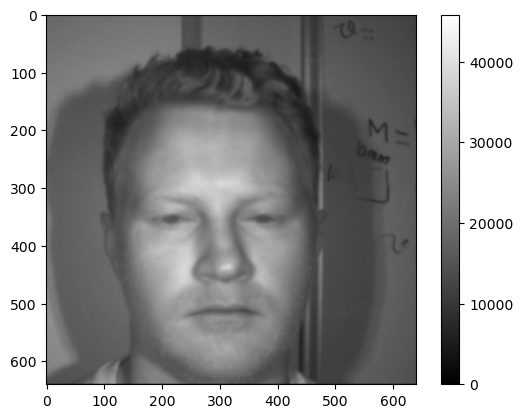

In [3]:
nir_img = cv2.imread(example_nir_img_path, cv2.IMREAD_UNCHANGED)
print(np.info(nir_img))
print(f"max pixel value: {nir_img.max()}, min pixel value: {nir_img.min()}")
plt.imshow(nir_img, cmap='gray')
plt.colorbar()


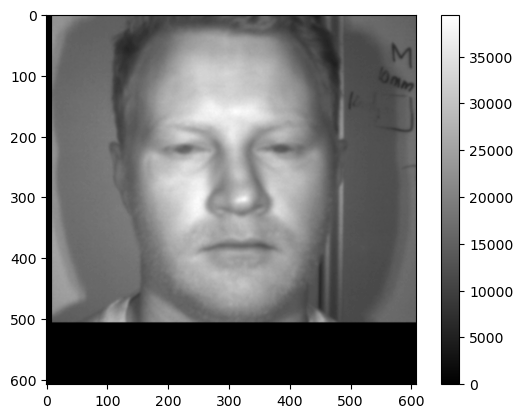

In [7]:
nir_img_face_locations = face_recognition.face_locations((nir_img / nir_img.max() * 255).astype(np.uint8))
for (top, right, bottom, left) in nir_img_face_locations:
    center_x, center_y = (left + right) // 2, (top + bottom) // 2
    face_size = max(right - left, bottom - top) * 1.9
    top, right = int(center_y - face_size // 2), int(center_x + face_size // 2)
    bottom, left = int(center_y + face_size // 2), int(center_x - face_size // 2)
    top_pad, bottom_pad = max(0, -top), max(0, bottom - nir_img.shape[0])
    left_pad, right_pad = max(0, -left), max(0, right - nir_img.shape[1])
    nir_img_pad = np.pad(nir_img, ((top_pad, bottom_pad), (left_pad, right_pad)),
                         mode='constant', constant_values=0)
    nir_img_face = nir_img_pad[top + top_pad : bottom + top_pad, left + left_pad : right + left_pad]
    plt.imshow(nir_img_face, cmap='gray')
    plt.colorbar()
    plt.show()

class:  ndarray
shape:  (36, 36)
strides:  (144, 4)
itemsize:  4
aligned:  True
contiguous:  True
fortran:  False
data pointer: 0x55a4cfb3b670
byteorder:  little
byteswap:  False
type: float32
max pixel value: 1.0, min pixel value: 3.663444658741355e-09


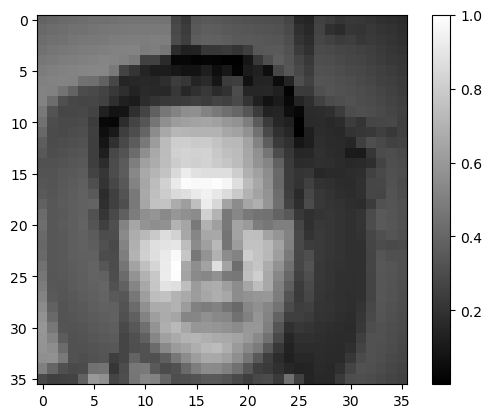

In [23]:
img_size_w, img_size_h = 36, 36
nir_img_normalized = cv2.normalize(cv2.resize(cv2.imread(example_nir_img_path, cv2.IMREAD_UNCHANGED), (img_size_w, img_size_h), interpolation=cv2.INTER_AREA),
                                   None, alpha=0, beta=1, norm_type=cv2.NORM_MINMAX, dtype=cv2.CV_32F).astype(np.float32)
np.info(nir_img_normalized)
print(f"max pixel value: {nir_img_normalized.max()}, min pixel value: {nir_img_normalized.min()}")
plt.imshow(nir_img_normalized, cmap='gray')
plt.colorbar()

class:  ndarray
shape:  (848, 848)
strides:  (1696, 2)
itemsize:  2
aligned:  True
contiguous:  True
fortran:  False
data pointer: 0x55a4d1e65310
byteorder:  little
byteswap:  False
type: uint16
None
max pixel value: 65472, min pixel value: 0


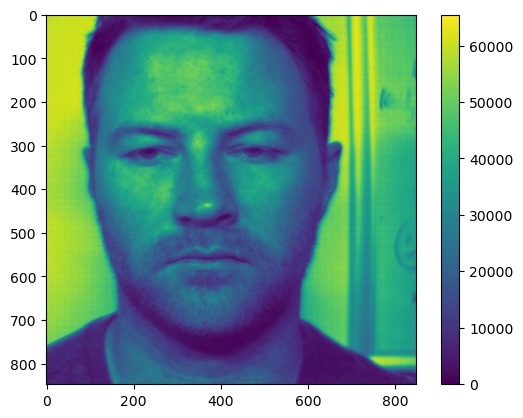

In [24]:
raw_img = cv2.imread(example_raw_img_path, cv2.IMREAD_UNCHANGED)  # Sensor format: RGGB
print(np.info(raw_img))
print(f"max pixel value: {raw_img.max()}, min pixel value: {raw_img.min()}")
plt.imshow(raw_img)
plt.colorbar()

class:  ndarray
shape:  (848, 848, 3)
strides:  (2544, 3, 1)
itemsize:  1
aligned:  True
contiguous:  True
fortran:  False
data pointer: 0x55a4d2099d00
byteorder:  little
byteswap:  False
type: uint8
None
max pixel value: 255, min pixel value: 0


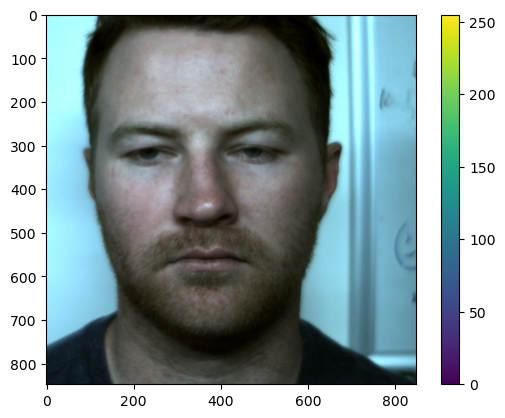

In [25]:
bayer_img = cv2.normalize(raw_img, None, 0, 255, cv2.NORM_MINMAX, cv2.CV_8U)  # Normalize raw image to 0-255
# Demosaic BGGR (or RGGB for subject6) raw image to RGB image
if 'Subject6' in example_subject_folder:
    rgb_img = cv2.cvtColor(bayer_img, cv2.COLOR_BayerBGGR2RGB)
else:
    rgb_img = cv2.cvtColor(bayer_img, cv2.COLOR_BayerRGGB2RGB)
print(np.info(rgb_img))
print(f"max pixel value: {rgb_img.max()}, min pixel value: {rgb_img.min()}")
plt.imshow(rgb_img)
plt.colorbar()

In [26]:
nir_img_list = sorted(glob.glob(os.path.join(example_nir_folder, "*.pgm")))
raw_img_list = sorted(glob.glob(os.path.join(example_raw_folder, "*.pgm")))
nir_img_name_list = [os.path.basename(img_path) for img_path in nir_img_list]
raw_img_name_list = [os.path.basename(img_path) for img_path in raw_img_list]
unmatched_frame_list = list(set(nir_img_name_list) ^ set(raw_img_name_list))
print(f"Number of NIR frame: {len(nir_img_list)}")
print(f"Number of RGB frame: {len(raw_img_list)}")
print(f"Unmatched frame: {unmatched_frame_list}")

Number of NIR frame: 5812
Number of RGB frame: 5811
Unmatched frame: ['Frame05811.pgm']


In [27]:
ppg_mat = sio.loadmat(example_ppg_mat_path)
for key in ppg_mat.keys():
    if key.startswith("__"):
        continue
    print(f"Key: {key}, type: {type(ppg_mat[key])}, shape: {ppg_mat[key].shape}, dtype: {ppg_mat[key].dtype}")
    print(f"Value: {ppg_mat[key]}\n")

Key: pulseOxRecord, type: <class 'numpy.ndarray'>, shape: (1, 10366), dtype: object
Value: [[array([[26]]) array([[26]]) array([[26]]) ... array([[33]])
  array([[32]])
  array([[32, 31, 31, 31, 32, 32, 32, 32, 32, 31, 31, 30, 30, 30, 29, 29,
          28, 28, 27, 27, 27, 27, 27, 26, 26]])                          ]]

Key: pulseOxTime, type: <class 'numpy.ndarray'>, shape: (1, 10366), dtype: float64
Value: [[1.51898779e+09 1.51898779e+09 1.51898779e+09 ... 1.51898797e+09
  1.51898797e+09 1.51898797e+09]]

Key: numPulseSample, type: <class 'numpy.ndarray'>, shape: (1, 1), dtype: int64
Value: [[10366]]



ppg_signal=

class:  ndarray
shape:  (10773,)
strides:  (8,)
itemsize:  8
aligned:  True
contiguous:  True
fortran:  True
data pointer: 0x55a4cd7b9200
byteorder:  little
byteswap:  False
type: int64

ppg_time=

class:  ndarray
shape:  (10773,)
strides:  (8,)
itemsize:  8
aligned:  True
contiguous:  True
fortran:  True
data pointer: 0x55a4cd905af0
byteorder:  little
byteswap:  False
type: float64


Text(0.5, 1.0, 'PPG Signal vs. Time')

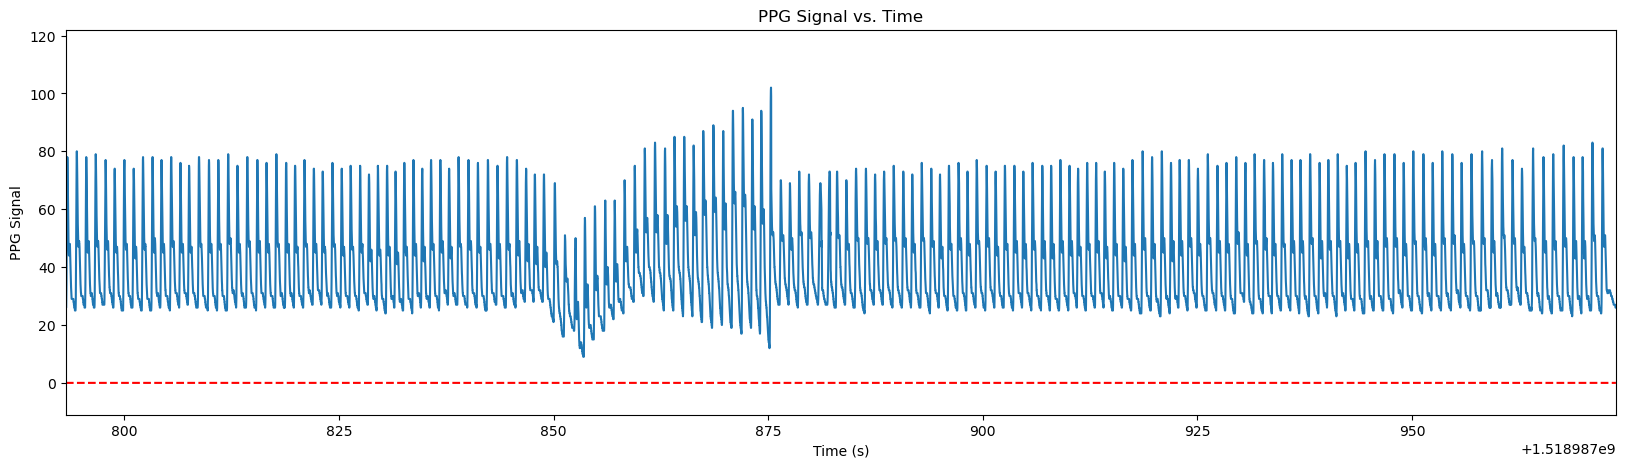

In [28]:
ppg_signal_corrupted = ppg_mat["pulseOxRecord"].squeeze()
ppg_time_corrupted = ppg_mat["pulseOxTime"][0]
ppg_signal, ppg_time = [], []
for idx, (value, time) in enumerate(zip(ppg_signal_corrupted, ppg_time_corrupted)):
    num_values = len(value[0]) if isinstance(value, np.ndarray) else 1
    if num_values > 1:  # Multiple values at a time step due to queued delayed ppg signal
        for sub_idx, sub_value in enumerate(value[0]):
            ppg_time.append(ppg_time_corrupted[idx-1] + ((sub_idx+1) / num_values) * (time - ppg_time_corrupted[idx-1]))
            ppg_signal.append(sub_value)
    else:
        ppg_time.append(time)
        ppg_signal.append(value.item())

ppg_signal = np.array(ppg_signal)
ppg_time = np.array(ppg_time)
print("ppg_signal=\n")
np.info(ppg_signal)
print('\nppg_time=\n')
np.info(ppg_time)

plt.figure(figsize=(20, 5))
plt.plot(ppg_time, ppg_signal)
plt.plot(ppg_time, np.zeros_like(ppg_time), 'r--')  # Zero means missing data, should not be used for training and evaluation
plt.xlim(ppg_time[0], ppg_time[-1])
plt.ylim(ppg_signal.min()-20, ppg_signal.max()+20)
plt.xlabel("Time (s)")
plt.ylabel("PPG Signal")
plt.title("PPG Signal vs. Time")

ppg_signal_resampled=

class:  ndarray
shape:  (5812,)
strides:  (8,)
itemsize:  8
aligned:  True
contiguous:  True
fortran:  True
data pointer: 0x55a4cd77a360
byteorder:  little
byteswap:  False
type: float64

ppg_time_resampled=

class:  ndarray
shape:  (5812,)
strides:  (8,)
itemsize:  8
aligned:  True
contiguous:  True
fortran:  True
data pointer: 0x55a4cd5087c0
byteorder:  little
byteswap:  False
type: float64


Text(0.5, 1.0, 'PPG Signal vs. Time (Resampled)')

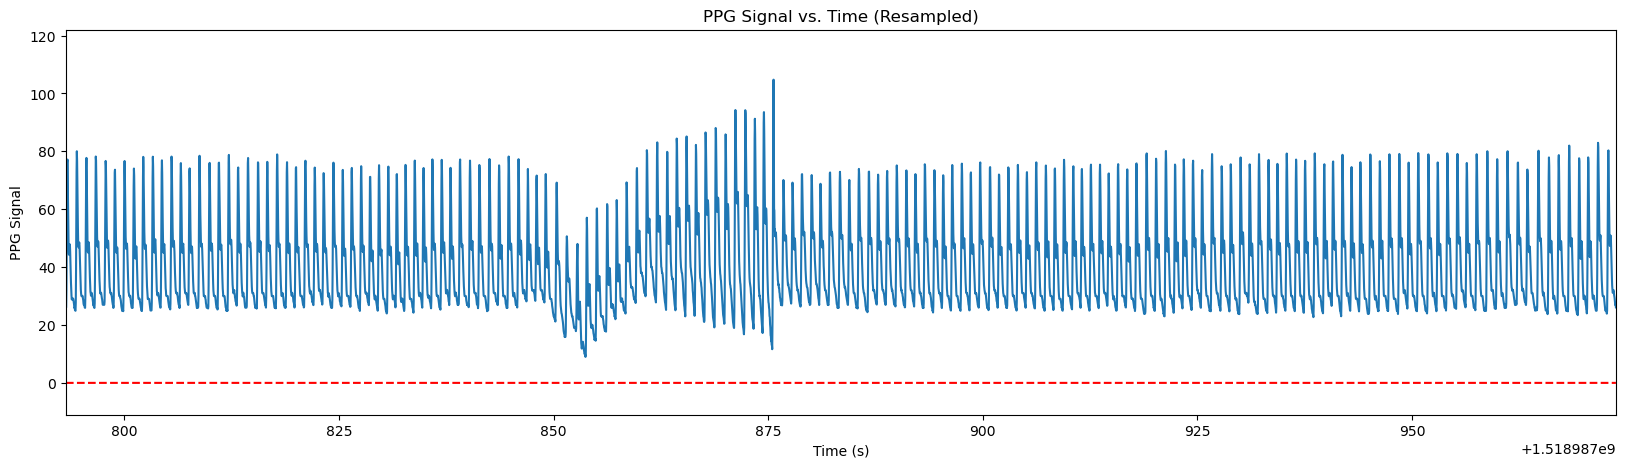

In [29]:
# Resample ppg_signal to the same size as nir_img_list
ppg_signal_resampled = sig.resample(ppg_signal, len(nir_img_list))
ppg_time_resampled = np.linspace(ppg_time[0], ppg_time[-1], len(nir_img_list))

print("ppg_signal_resampled=\n")
np.info(ppg_signal_resampled)
print('\nppg_time_resampled=\n')
np.info(ppg_time_resampled)

plt.figure(figsize=(20, 5))
plt.plot(ppg_time_resampled, ppg_signal_resampled)
plt.plot(ppg_time_resampled, np.zeros_like(ppg_time_resampled), 'r--')  # Zero means missing data, should not be used for training and evaluation
plt.xlim(ppg_time[0], ppg_time[-1])
plt.ylim(ppg_signal.min()-20, ppg_signal.max()+20)
plt.xlabel("Time (s)")
plt.ylabel("PPG Signal")
plt.title("PPG Signal vs. Time (Resampled)")

Text(0.5, 1.0, 'PPG Signal vs. Time (interpolated)')

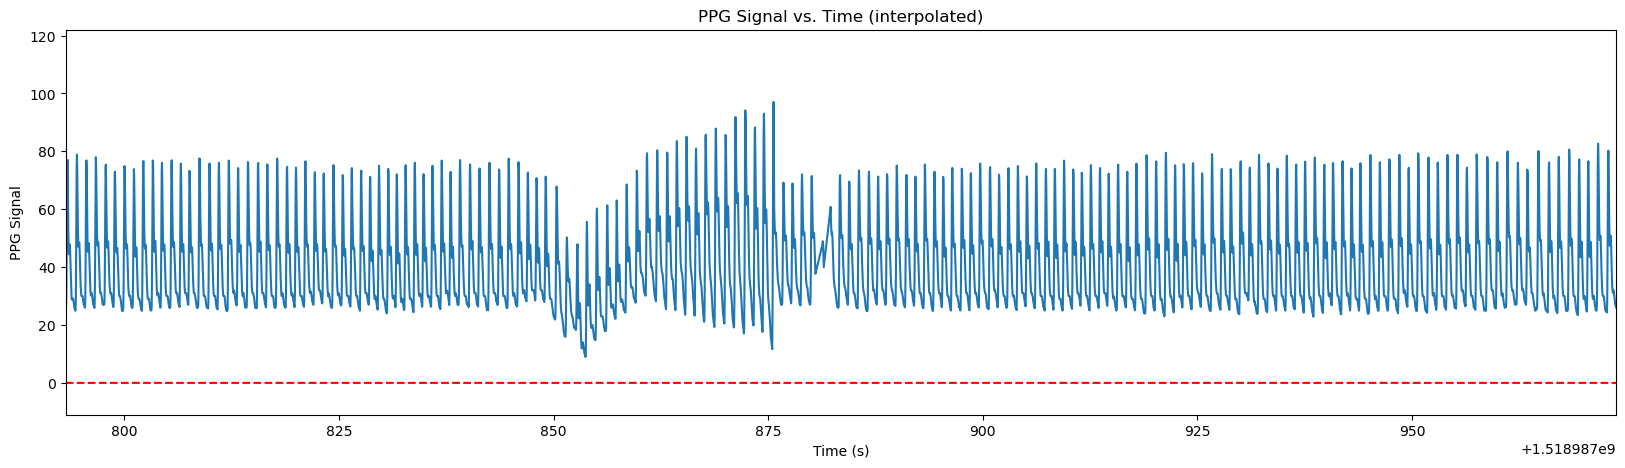

In [30]:
nir_time = np.loadtxt(example_nir_time_path)
# Align nir_time to ppg_time
ppg_signal_interpolated = []
for t in nir_time:
    # Interpolate ppg_signal to nir_time
    idx = np.searchsorted(ppg_time_resampled, t)
    if idx == 0:
        ppg_signal_interpolated.append(ppg_signal_resampled[idx])
    elif idx == len(ppg_time_resampled):
        ppg_signal_interpolated.append(ppg_signal_resampled[idx-1])
    else:
        ppg_signal_interpolated.append(ppg_signal_resampled[idx-1] + (t - ppg_time_resampled[idx-1]) * (ppg_signal_resampled[idx] - ppg_signal_resampled[idx-1]) / (ppg_time_resampled[idx] - ppg_time_resampled[idx-1]))

ppg_signal_interpolated = np.array(ppg_signal_interpolated)

plt.figure(figsize=(20, 5))
plt.plot(nir_time, ppg_signal_interpolated)
plt.plot(nir_time, np.zeros_like(nir_time), 'r--')  # Zero means missing data, should not be used for training and evaluation
plt.xlim(ppg_time[0], ppg_time[-1])
plt.ylim(ppg_signal.min()-20, ppg_signal.max()+20)
plt.xlabel("Time (s)")
plt.ylabel("PPG Signal")
plt.title("PPG Signal vs. Time (interpolated)")


Text(0.5, 1.0, 'PPG Signal vs. Time (differentiated)')

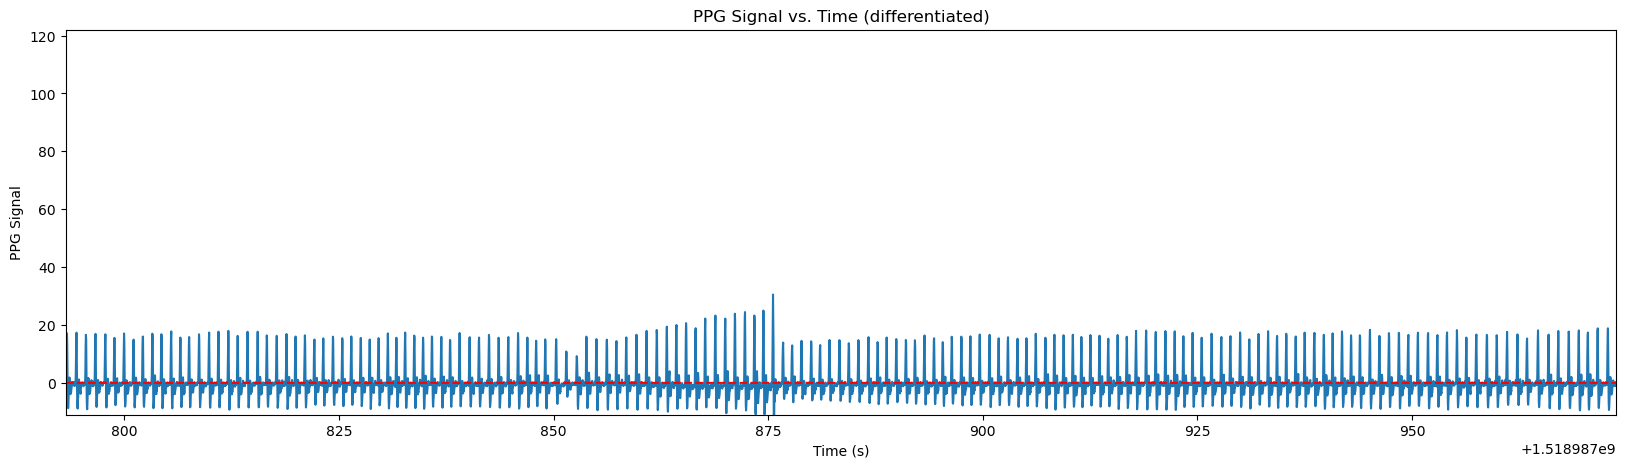

In [31]:
ppg_signal_diff = np.diff(ppg_signal_resampled)
ppg_signal_diff = np.concatenate(([ppg_signal_diff[0]], ppg_signal_diff))
plt.figure(figsize=(20, 5))
plt.plot(ppg_time_resampled, ppg_signal_diff)
plt.plot(ppg_time_resampled, np.zeros_like(ppg_time_resampled), 'r--')  # Zero means missing data, should not be used for training and evaluation
plt.xlim(ppg_time[0], ppg_time[-1])
plt.ylim(ppg_signal.min()-20, ppg_signal.max()+20)
plt.xlabel("Time (s)")
plt.ylabel("PPG Signal")
plt.title("PPG Signal vs. Time (differentiated)")


class:  ndarray
shape:  (5811,)
strides:  (8,)
itemsize:  8
aligned:  True
contiguous:  True
fortran:  True
data pointer: 0x55a4d39b0390
byteorder:  little
byteswap:  False
type: float64
MSE between ppg_signal_dl and 0: 26.68811021104037
MSE between ppg_signal_dl and average of ppg_signal_dl: 26.688110210975882


Text(0.5, 1.0, 'PPG Signal vs. Time (DL)')

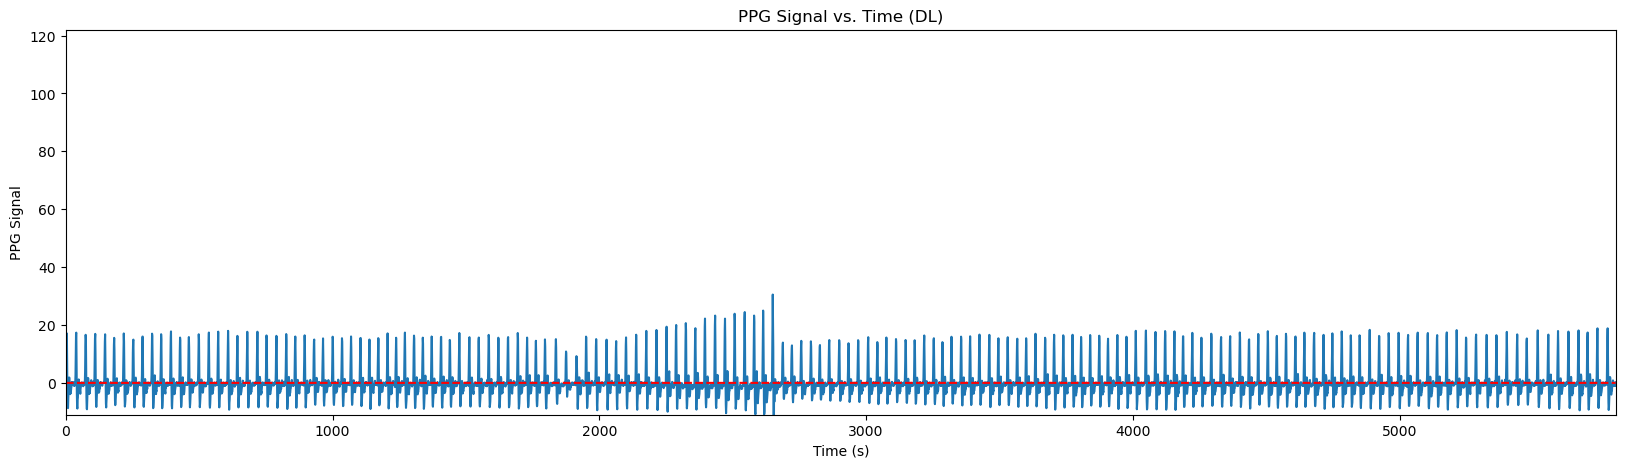

In [32]:
window_size = 2
ppg_signal_dl = []
for idx in range(0, len(ppg_signal_resampled) - window_size + 1):
    if np.any(ppg_signal_resampled[idx:idx+window_size] < 1):
        continue
    ppg_signal_dl.append(ppg_signal_resampled[idx+1] - ppg_signal_resampled[idx])
ppg_signal_dl = np.array(ppg_signal_dl)
np.info(ppg_signal_dl)

# Calculate the MSE between ppg_signal_interpolated and 0
mse = np.mean(np.square(ppg_signal_dl))
print(f"MSE between ppg_signal_dl and 0: {mse}")

# Calculate the MSE between ppg_signal_interpolated and average of ppg_signal_interpolated
mse = np.mean(np.square(ppg_signal_dl - np.mean(ppg_signal_dl)))
print(f"MSE between ppg_signal_dl and average of ppg_signal_dl: {mse}")

plt.figure(figsize=(20, 5))
plt.plot(ppg_signal_dl)
plt.plot(np.zeros_like(ppg_signal_dl), 'r--')  # Zero means missing data, should not be used for training and evaluation
plt.xlim(0, len(ppg_signal_dl))
plt.ylim(ppg_signal.min()-20, ppg_signal.max()+20)
plt.xlabel("Time (s)")
plt.ylabel("PPG Signal")
plt.title("PPG Signal vs. Time (DL)")

class:  ndarray
shape:  (5811,)
strides:  (8,)
itemsize:  8
aligned:  True
contiguous:  True
fortran:  True
data pointer: 0x55a4d2a83270
byteorder:  little
byteswap:  False
type: float64


Text(0.5, 1.0, 'PPG Signal vs. Time (DL scaled with 1/std within every window)')

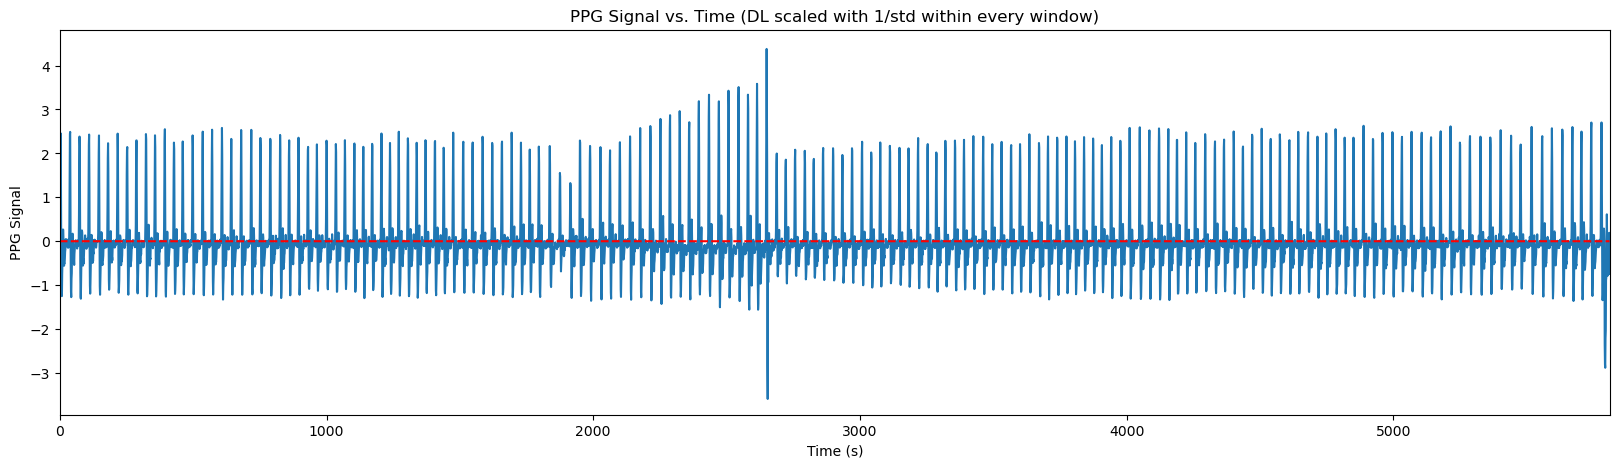

In [33]:
window_size = 32
ppg_signal_dl_scaled = []
# Divide ppg_signal_dl with its standard deviation within every window of window_size and stride windwo_size
for idx in range(0, len(ppg_signal_dl) - window_size + 1, window_size):
    # ppg_signal_dl_scaled.extend(ppg_signal_dl[idx:idx+window_size] / np.std(ppg_signal_dl[idx:idx+window_size]))
    ppg_signal_dl_scaled.extend(ppg_signal_dl[idx:idx+window_size] / 6.969092845916748)
ppg_signal_dl_scaled.extend(ppg_signal_dl[idx+window_size:] / np.std(ppg_signal_dl[idx+window_size:]))
ppg_signal_dl_scaled = np.array(ppg_signal_dl_scaled)
np.info(ppg_signal_dl_scaled)

plt.figure(figsize=(20, 5))
plt.plot(ppg_signal_dl_scaled)
plt.plot(np.zeros_like(ppg_signal_dl_scaled), 'r--')  # Zero means missing data, should not be used for training and evaluation
plt.xlim(0, len(ppg_signal_dl_scaled))
plt.ylim(ppg_signal_dl_scaled.min() * 1.1, ppg_signal_dl_scaled.max() * 1.1)
plt.xlabel("Time (s)")
plt.ylabel("PPG Signal")
plt.title("PPG Signal vs. Time (DL scaled with 1/std within every window)")

class:  ndarray
shape:  (5811,)
strides:  (8,)
itemsize:  8
aligned:  True
contiguous:  True
fortran:  True
data pointer: 0x55a4d45575d0
byteorder:  little
byteswap:  False
type: float64


Text(0.5, 1.0, 'PPG Signal vs. Time (DL scaled with fixed std)')

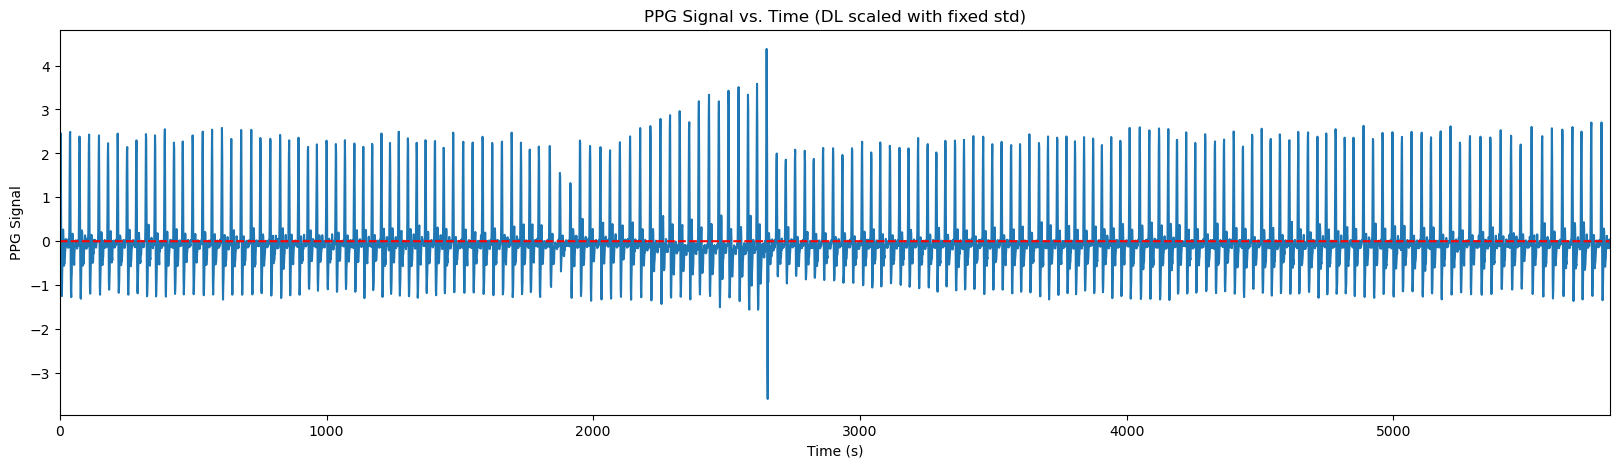

In [34]:
fixed_std = 6.9690316028882915
ppg_signal_dl_fixed_scaled = ppg_signal_dl / fixed_std
np.info(ppg_signal_dl_fixed_scaled)

plt.figure(figsize=(20, 5))
plt.plot(ppg_signal_dl_fixed_scaled)
plt.plot(np.zeros_like(ppg_signal_dl_fixed_scaled), 'r--')  # Zero means missing data, should not be used for training and evaluation
plt.xlim(0, len(ppg_signal_dl_fixed_scaled))
plt.ylim(ppg_signal_dl_scaled.min() * 1.1, ppg_signal_dl_scaled.max() * 1.1)
plt.xlabel("Time (s)")
plt.ylabel("PPG Signal")
plt.title("PPG Signal vs. Time (DL scaled with fixed std)")

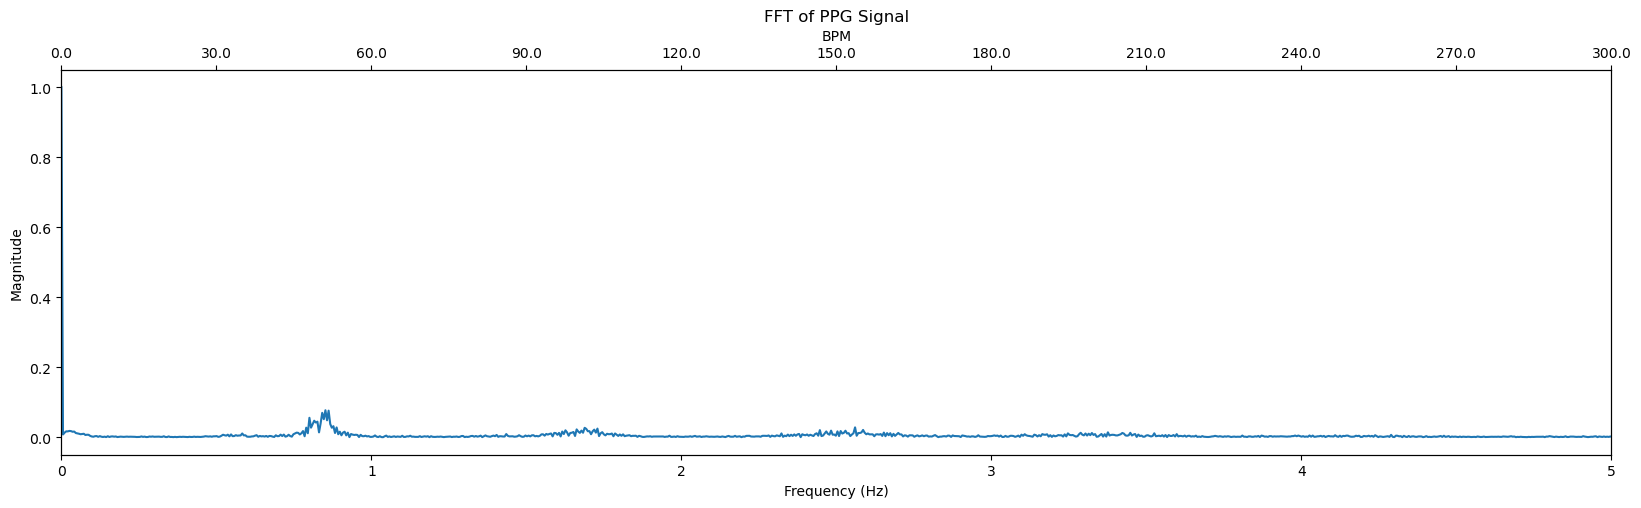

In [35]:
# FFT on ppg_signal_resampled
Fs = 30  # Sampling frequency
ppg_signal_fft = np.fft.rfft(ppg_signal_resampled)
ppg_signal_fft_abs = np.abs(ppg_signal_fft)
ppg_signal_fft_abs = ppg_signal_fft_abs / np.max(ppg_signal_fft_abs)
ppg_signal_fft_freq = np.fft.rfftfreq(len(ppg_signal_resampled), d=1/Fs)
plt.figure(figsize=(20, 5))
plt.plot(ppg_signal_fft_freq, ppg_signal_fft_abs)
plt.xlim(0, 5)  # Only show the first 5 Hz (~= 300 bpm)
plt.xlabel("Frequency (Hz)")
plt.ylabel("Magnitude")
plt.title("FFT of PPG Signal")
# Add another x-axis for bpm
ax2 = plt.gca().twiny()
ax2.set_xlim(0, 5)
ax2.set_xlabel("BPM")
ax2.set_xticks(np.arange(0, 5.1, 0.5) * 60)  # 1 Hz = 60 bpm
ax2.set_xticklabels(np.arange(0, 5.1, 0.5) * 60)
plt.show()


Text(0.5, 1.0, 'PPG Signal vs. Time (Detrended)')

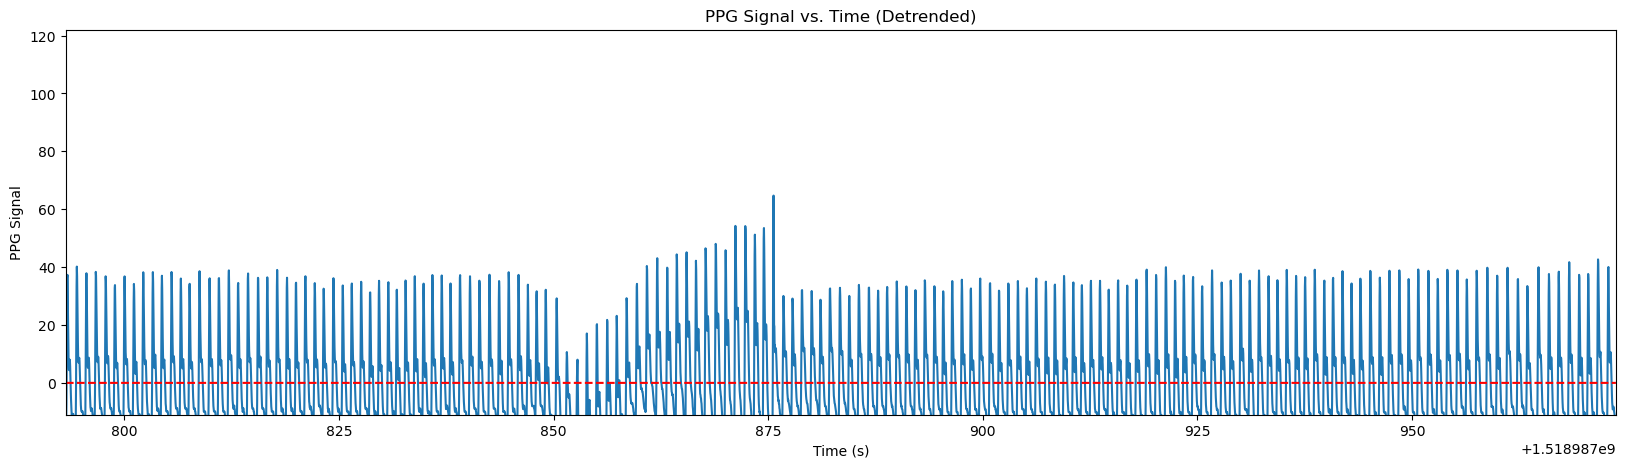

In [36]:
# Detrend ppg_signal_resampled
ppg_signal_detrend = sig.detrend(ppg_signal_resampled)
plt.figure(figsize=(20, 5))
plt.plot(ppg_time_resampled, ppg_signal_detrend)
plt.plot(ppg_time_resampled, np.zeros_like(ppg_time_resampled), 'r--')  # Zero means missing data, should not be used for training and evaluation
plt.xlim(ppg_time[0], ppg_time[-1])
plt.ylim(ppg_signal.min()-20, ppg_signal.max()+20)
plt.xlabel("Time (s)")
plt.ylabel("PPG Signal")
plt.title("PPG Signal vs. Time (Detrended)")

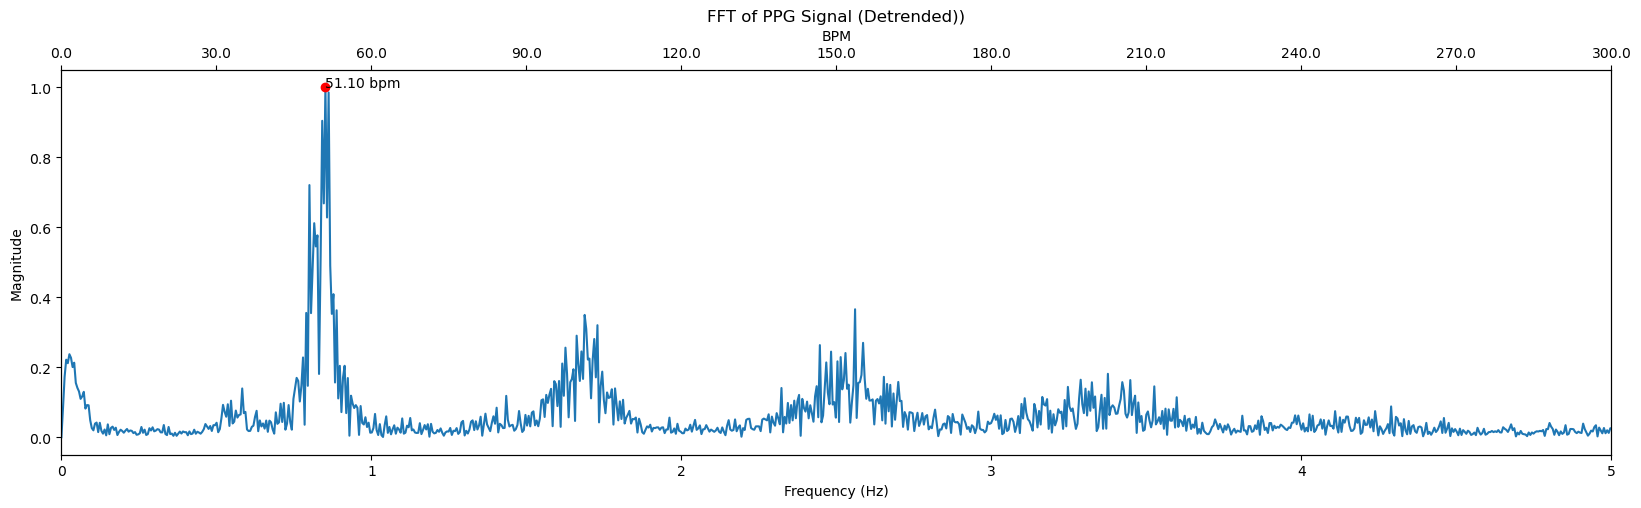

In [37]:
# FFT on ppg_signal_detrended
Fs = 30  # Sampling frequency
ppg_signal_fft_detrend = np.fft.rfft(ppg_signal_detrend)
ppg_signal_fft_abs_detrend = np.abs(ppg_signal_fft_detrend)
ppg_signal_fft_abs_detrend = ppg_signal_fft_abs_detrend / np.max(ppg_signal_fft_abs_detrend)
ppg_signal_fft_freq_detrend = np.fft.rfftfreq(len(ppg_signal_detrend), d=1/Fs)
plt.figure(figsize=(20, 5))
plt.plot(ppg_signal_fft_freq_detrend, ppg_signal_fft_abs_detrend)

# Mark the max peak
max_peak_idx_detrend = np.argmax(ppg_signal_fft_abs_detrend)
max_peak_freq_detrend = ppg_signal_fft_freq_detrend[max_peak_idx_detrend]
max_peak_bpm_detrend = max_peak_freq_detrend * 60  # 1 Hz = 60 bpm
max_peak_mag_detrend = ppg_signal_fft_abs_detrend[max_peak_idx_detrend]
plt.plot(max_peak_freq_detrend, max_peak_mag_detrend, 'ro')
plt.annotate(f"{max_peak_bpm_detrend:.2f} bpm", (max_peak_freq_detrend, max_peak_mag_detrend))

plt.xlim(0, 5)  # Only show the first 5 Hz (~= 300 bpm)
plt.xlabel("Frequency (Hz)")
plt.ylabel("Magnitude")
plt.title("FFT of PPG Signal (Detrended))")

# Add another x-axis for bpm
ax2 = plt.gca().twiny()
ax2.set_xlim(0, 5)
ax2.set_xlabel("BPM")
ax2.set_xticks(np.arange(0, 5.1, 0.5) * 60)  # 1 Hz = 60 bpm
ax2.set_xticklabels(np.arange(0, 5.1, 0.5) * 60)

plt.show()


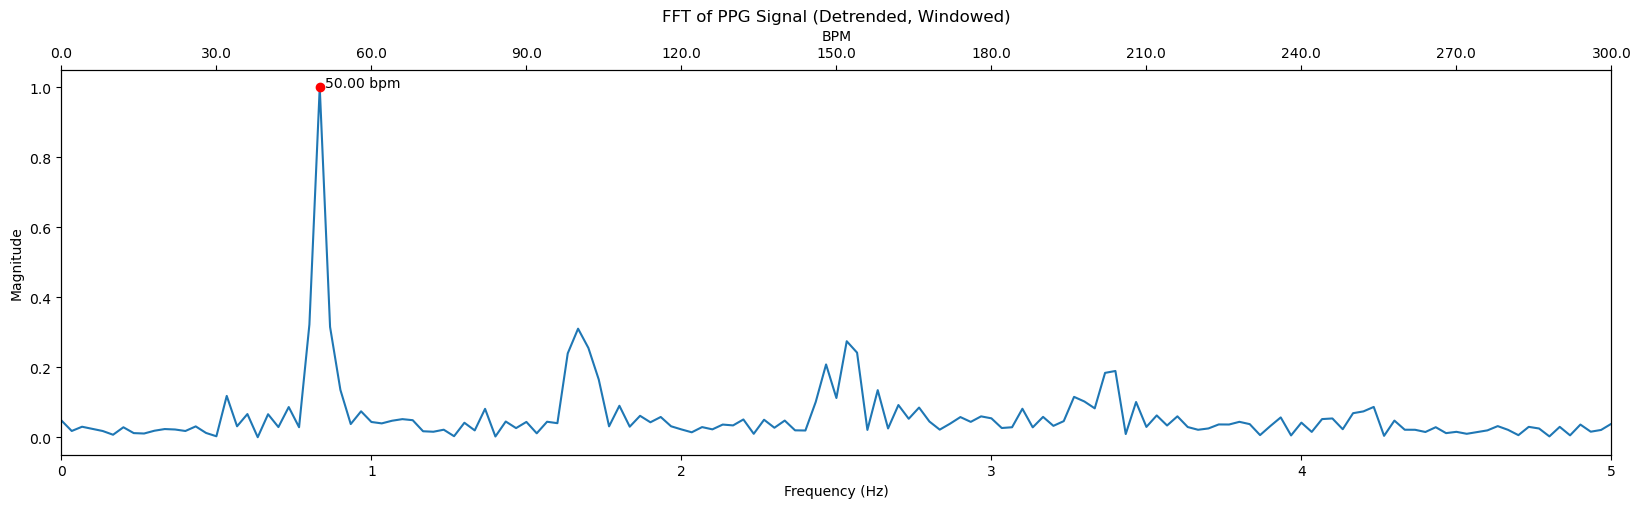

In [38]:
# FFT on ppg_signal_detrended
Fs = 30  # Sampling frequency
ppg_signal_detrend_window = ppg_signal_detrend[:900]
ppg_signal_fft_detrend_window = np.fft.rfft(ppg_signal_detrend_window)
ppg_signal_fft_abs_detrend_window = np.abs(ppg_signal_fft_detrend_window)
ppg_signal_fft_abs_detrend_window = ppg_signal_fft_abs_detrend_window / np.max(ppg_signal_fft_abs_detrend_window)
ppg_signal_fft_freq_detrend_window = np.fft.rfftfreq(len(ppg_signal_detrend_window), d=1/Fs)
plt.figure(figsize=(20, 5))
plt.plot(ppg_signal_fft_freq_detrend_window, ppg_signal_fft_abs_detrend_window)

# Mark the max peak
max_peak_idx_detrend_window = np.argmax(ppg_signal_fft_abs_detrend_window)
max_peak_freq_detrend_window = ppg_signal_fft_freq_detrend_window[max_peak_idx_detrend_window]
max_peak_bpm_detrend_window = max_peak_freq_detrend_window * 60  # 1 Hz = 60 bpm
max_peak_mag_detrend_window = ppg_signal_fft_abs_detrend_window[max_peak_idx_detrend_window]
plt.plot(max_peak_freq_detrend_window, max_peak_mag_detrend_window, 'ro')
plt.annotate(f"{max_peak_bpm_detrend_window:.2f} bpm", (max_peak_freq_detrend, max_peak_mag_detrend_window))

plt.xlim(0, 5)  # Only show the first 5 Hz (~= 300 bpm)
plt.xlabel("Frequency (Hz)")
plt.ylabel("Magnitude")
plt.title("FFT of PPG Signal (Detrended, Windowed)")

# Add another x-axis for bpm
ax2 = plt.gca().twiny()
ax2.set_xlim(0, 5)
ax2.set_xlabel("BPM")
ax2.set_xticks(np.arange(0, 5.1, 0.5) * 60)  # 1 Hz = 60 bpm
ax2.set_xticklabels(np.arange(0, 5.1, 0.5) * 60)

plt.show()
